In [6]:
import numpy as np
from scipy.stats import beta
import math
import cv2
import pandas as pd
import time
import tqdm
import matplotlib.pyplot as plt

def distribution_pmf(dist, start: float, stop: float, nr_of_steps: int):
    xs = np.linspace(start, stop, nr_of_steps)
    ys = dist.pdf(xs)
    return ys / np.sum(ys)

RED_PMF = distribution_pmf(beta(2, 2), 0, 1, 256)    

def get_resolution(image: np.ndarray):
    height, width = image.shape[:2]
    return height * width

def brightness_histogram(image: np.ndarray) -> np.ndarray:
    nr_of_pixels = get_resolution(image)
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_brightness = image_hsv[:, :, 2]
    hist, _ = np.histogram(hsv_brightness, bins=256, range=(0, 255))
    del image_hsv
    return hist / nr_of_pixels
    
def correlation_distance(
    distribution_a: np.ndarray, distribution_b: np.ndarray
) -> float:
    dot_product = np.dot(distribution_a, distribution_b)
    squared_dist_a = np.sum(distribution_a ** 2)
    squared_dist_b = np.sum(distribution_b ** 2)
    return dot_product / math.sqrt(squared_dist_a * squared_dist_b)

def compute_hdr(img: np.ndarray):
    img_brightness_pmf = brightness_histogram(img)
    return correlation_distance(RED_PMF, img_brightness_pmf)

def compute_brightness_base(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_brightness = np.mean(image_hsv[:, :, 2])

    del image_hsv
    
    return hsv_brightness

100%|██████████| 4990/4990 [00:02<00:00, 1881.76it/s]


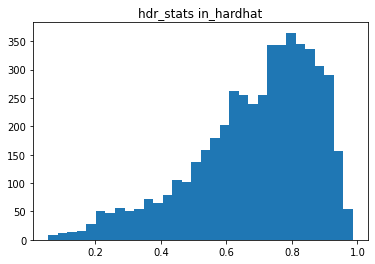

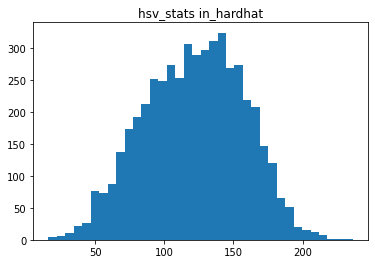

100%|██████████| 422/422 [00:00<00:00, 1333.42it/s]


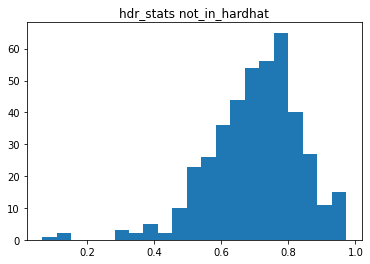

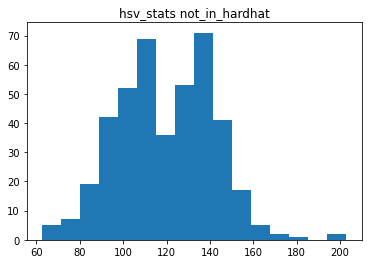

100%|██████████| 1491/1491 [00:00<00:00, 1823.48it/s]


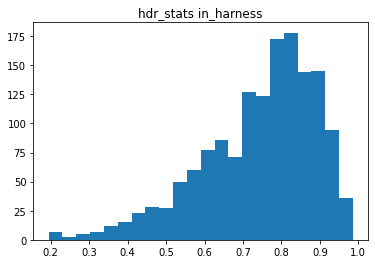

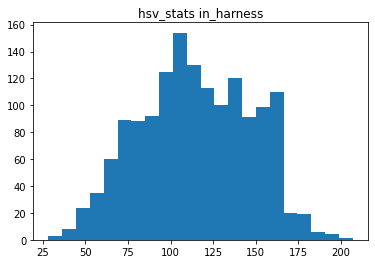

100%|██████████| 4995/4995 [00:02<00:00, 1853.22it/s]


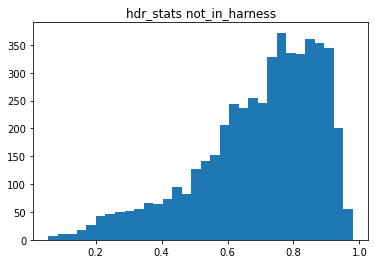

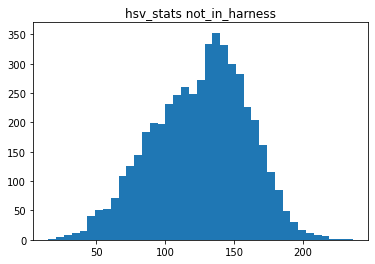

100%|██████████| 5659/5659 [00:03<00:00, 1875.87it/s]


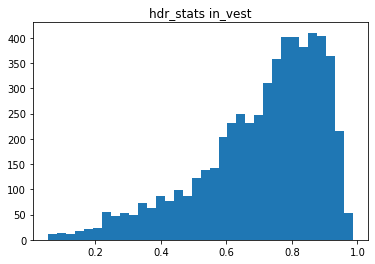

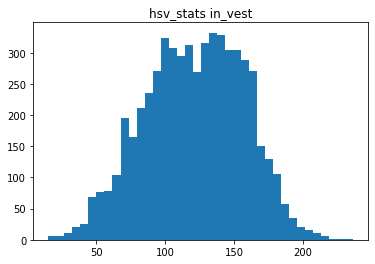

100%|██████████| 1047/1047 [00:00<00:00, 1819.16it/s]


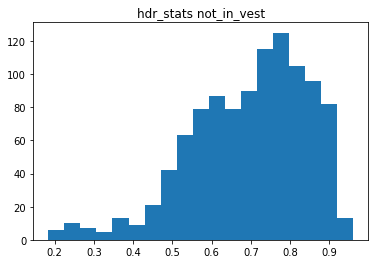

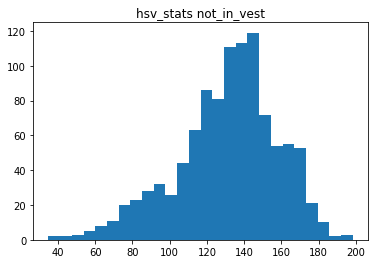

In [12]:
def get_class_stats_distribution(images_path,label):
    hdr_stats = []
    hsv_stats = []
    for path in tqdm.tqdm(images_path):
        image = cv2.imread(f'/home/rodion/crops/dataset_ppe/crops/{path}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        image = cv2.resize(image,(80,185))
        hdr = compute_hdr(image)
        hsv = compute_brightness_base(image)
        hdr_stats.append(hdr)
        hsv_stats.append(hsv)

    hdr_stats_np = np.array(hdr_stats)
    hsv_stats_np = np.array(hsv_stats)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(hdr_stats_np, bins='auto')
    plt.title(f'hdr_stats {label}')
    fig.savefig(f'/home/rodion/pytorch_lightning_classification/multilabel/brightness_contrast/dists/hdr_stats_{label}.jpg')
    plt.show()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.hist(hsv_stats_np, bins='auto')
    plt.title(f'hsv_stats {label}')
    fig.savefig(f'/home/rodion/pytorch_lightning_classification/multilabel/brightness_contrast/dists/hsv_stats_{label}.jpg')
    plt.show()

df = pd.read_csv('/home/rodion/crops/dataset_ppe/ann/val.csv')

images_path = df[(df['hardhat']=='in_hardhat')]['image_path'].values
get_class_stats_distribution(images_path,'in_hardhat')

images_path = df[(df['hardhat']=='not_in_hardhat')]['image_path'].values
get_class_stats_distribution(images_path,'not_in_hardhat')

images_path = df[(df['harness']=='in_harness')]['image_path'].values
get_class_stats_distribution(images_path,'in_harness')

images_path = df[(df['harness']=='not_in_harness')]['image_path'].values
get_class_stats_distribution(images_path,'not_in_harness')

images_path = df[(df['vest']=='in_vest')]['image_path'].values
get_class_stats_distribution(images_path,'in_vest')

images_path = df[(df['vest']=='not_in_vest')]['image_path'].values
get_class_stats_distribution(images_path,'not_in_vest')

In [39]:
hdr_th_list = np.linspace(0,0.5,11).round(2)
print(hdr_th_list)
hsv_th_list = np.concatenate((np.linspace(0,50,6).round(2), np.linspace(75,175,5).round(2), np.linspace(185,245,7).round(2)))
print(hsv_th_list)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]
[  0.  10.  20.  30.  40.  50.  75. 100. 125. 150. 175. 185. 195. 205.
 215. 225. 235. 245.]


In [40]:
import pandas as pd
import cv2
import numpy as np
import math
import pandas as pd
import cv2
import time
import tqdm

def get_stats_dict_by_class(images_path):
    
    hdr_th_dict = {}
    hsv_th_dict = {}
    for i in range(len(hdr_th_list)-1):
        hdr_th_dict.update({(hdr_th_list[i],hdr_th_list[i+1]):[]})
    for i in range(len(hsv_th_list)-1):
        hsv_th_dict.update({(hsv_th_list[i],hsv_th_list[i+1]):[]})

    for i,path in enumerate(tqdm.tqdm(images_path)):
        image = cv2.imread(f'/home/rodion/crops/dataset_ppe/crops/{path}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        image = cv2.resize(image,(80,185))
        hdr = compute_hdr(image)
        hsv = compute_brightness_base(image)

        for rangin in list(hdr_th_dict.keys()):
            if rangin[0] <= hdr and rangin[1] > hdr:
                hdr_th_dict[rangin].append(path)
                break

        for rangin in list(hsv_th_dict.keys()):
            if rangin[0] <= hsv and rangin[1] > hsv:
                hsv_th_dict[rangin].append(path)
                break    

    return hdr_th_dict,hsv_th_dict

In [41]:
FONTSCALE = 0.55
THICKNESS = 1
LINETYPE = 1
FONTFACE = cv2.FONT_HERSHEY_DUPLEX


def create_grid(images_path,label):  
    hdr_th_dict,hsv_th_dict = get_stats_dict_by_class(images_path)

    for rangin in list(hdr_th_dict.keys()):
        images_in_row = []
        images_all = []
        for image_path in hdr_th_dict[rangin]:
            image = cv2.imread(f'/home/rodion/crops/dataset_ppe/crops/{image_path}')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
            image = cv2.resize(image,(80,185))
            images_in_row.append(image)
            if len(images_in_row) == 2:
                images_in_row = np.concatenate(images_in_row, axis=1)
                images_in_row_shape = images_in_row.shape
                images_all.append(images_in_row)
                images_in_row = []
            
            if len(images_all)==10:
                break

        if len(images_all)>0:
            blank = (np.ones(images_in_row_shape)*255).astype(image.dtype)
            blank = cv2.putText(blank, f"hdr_{str(rangin)}", (5,30), FONTFACE, FONTSCALE,
                                    (0,0,0), THICKNESS, LINETYPE)
            blank = cv2.putText(blank, str(label), (10,70), FONTFACE, FONTSCALE,
                                    (0,0,0), THICKNESS, LINETYPE)                     
            images_all.append(blank)
            images_all = np.concatenate(images_all, axis=0)
            images_all = cv2.cvtColor(images_all, cv2.COLOR_RGB2BGR)
            plt.imshow(images_all)
            plt.show() 
            cv2.imwrite(f'brightness_contrast/extra/hdr_{str(rangin)}-{label}.jpg',images_all)

    for rangin in list(hsv_th_dict.keys()):
        images_in_row = []
        images_all = []
        for image_path in hsv_th_dict[rangin]:
            image = cv2.imread(f'/home/rodion/crops/dataset_ppe/crops/{image_path}')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
            image = cv2.resize(image,(80,185))
            images_in_row.append(image)
            if len(images_in_row) == 2:
                images_in_row = np.concatenate(images_in_row, axis=1)
                images_in_row_shape = images_in_row.shape
                images_all.append(images_in_row)
                images_in_row = []
            if len(images_all)==10:
                break
        
        if len(images_all)>0:
            blank = (np.ones(images_in_row_shape)*255).astype(image.dtype)
            blank = cv2.putText(blank, f"br_{str(rangin)}", (5,30), FONTFACE, FONTSCALE,
                                    (0,0,0), THICKNESS, LINETYPE)
            blank = cv2.putText(blank, str(label), (10,70), FONTFACE, FONTSCALE,
                                    (0,0,0), THICKNESS, LINETYPE)   
            images_all.append(blank)
            images_all = np.concatenate(images_all, axis=0)
            images_all = cv2.cvtColor(images_all, cv2.COLOR_RGB2BGR)
            plt.imshow(images_all)
            plt.show() 
            cv2.imwrite(f'brightness_contrast/final/brightness_{str(rangin)}-{label}.jpg',images_all)

    del hdr_th_dict,hsv_th_dict

100%|██████████| 4990/4990 [00:03<00:00, 1641.82it/s]


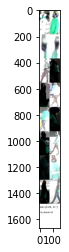

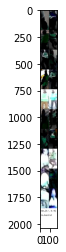

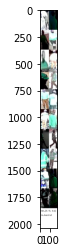

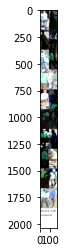

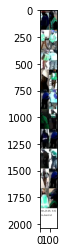

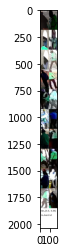

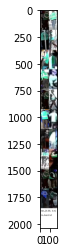

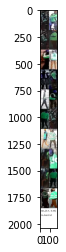

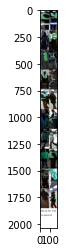

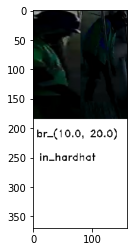

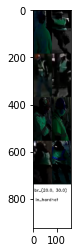

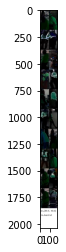

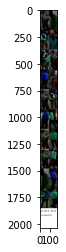

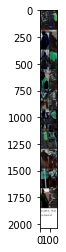

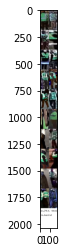

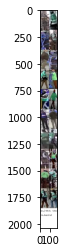

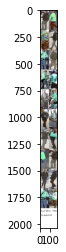

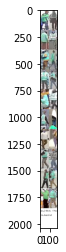

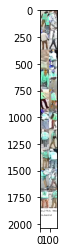

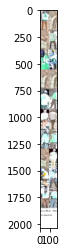

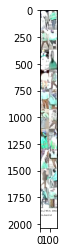

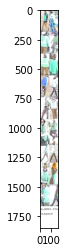

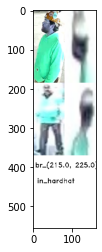

100%|██████████| 422/422 [00:00<00:00, 1096.06it/s]


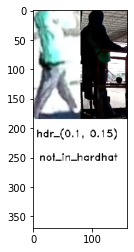

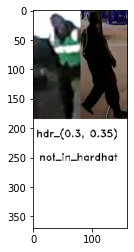

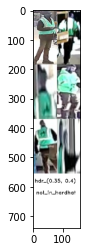

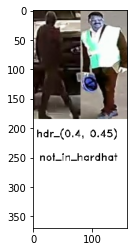

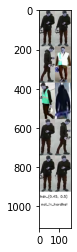

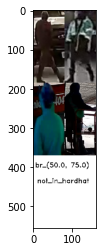

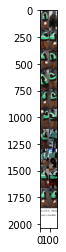

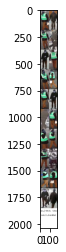

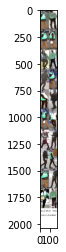

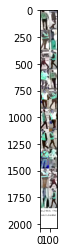

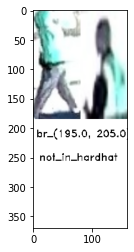

100%|██████████| 1491/1491 [00:01<00:00, 1392.31it/s]


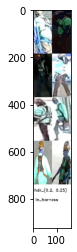

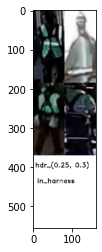

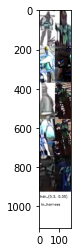

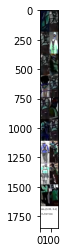

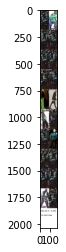

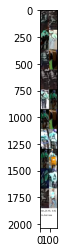

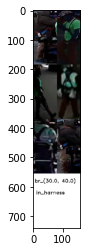

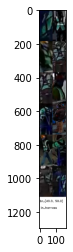

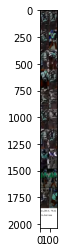

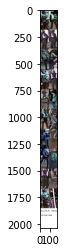

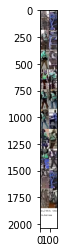

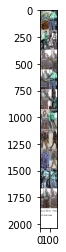

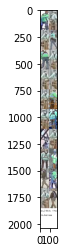

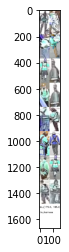

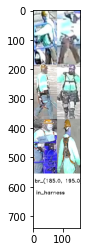

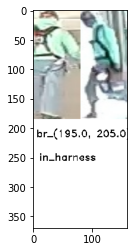

100%|██████████| 4995/4995 [00:03<00:00, 1539.10it/s]


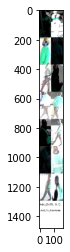

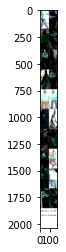

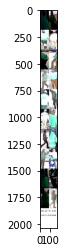

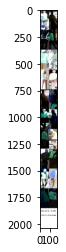

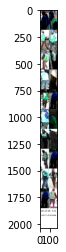

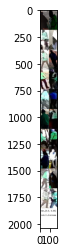

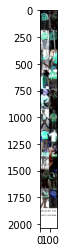

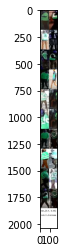

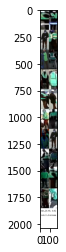

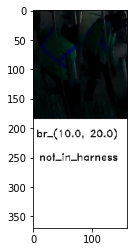

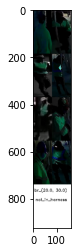

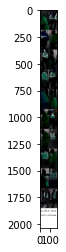

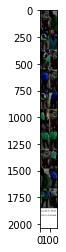

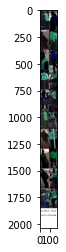

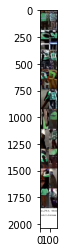

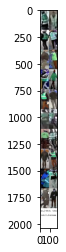

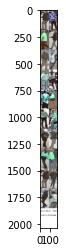

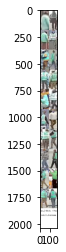

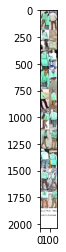

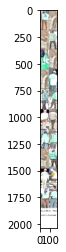

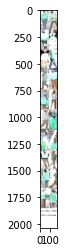

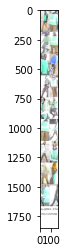

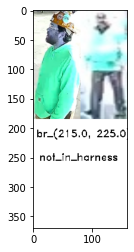

100%|██████████| 5659/5659 [00:03<00:00, 1599.54it/s]


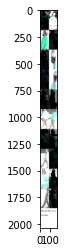

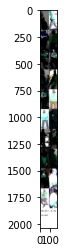

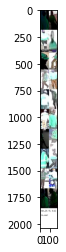

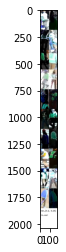

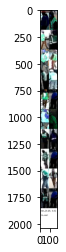

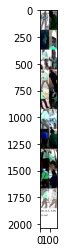

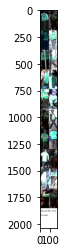

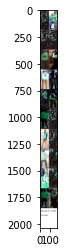

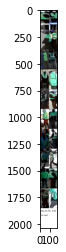

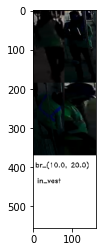

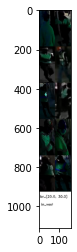

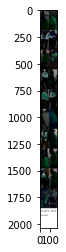

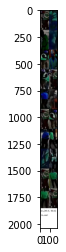

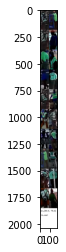

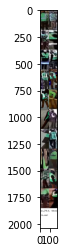

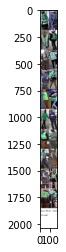

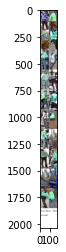

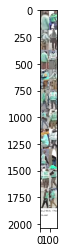

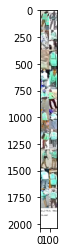

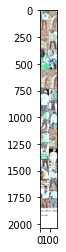

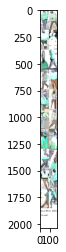

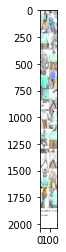

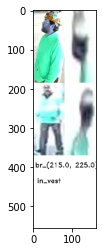

100%|██████████| 1047/1047 [00:00<00:00, 1435.05it/s]


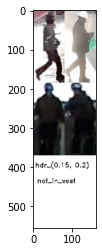

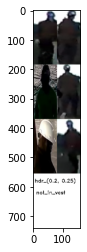

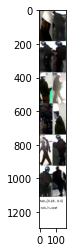

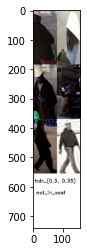

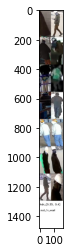

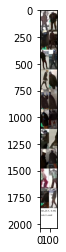

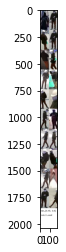

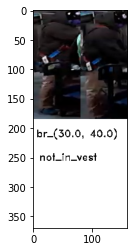

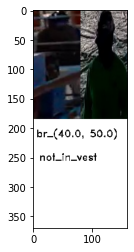

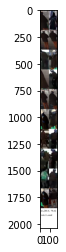

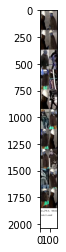

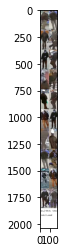

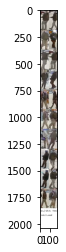

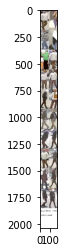

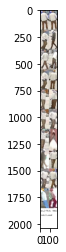

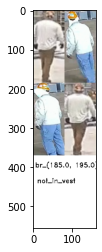

In [42]:
df = pd.read_csv('/home/rodion/crops/dataset_ppe/ann/val.csv')

df = df.sample(frac=1)

images_path = df[(df['hardhat']=='in_hardhat')]['image_path'].values
create_grid(images_path,'in_hardhat')

images_path = df[(df['hardhat']=='not_in_hardhat')]['image_path'].values
create_grid(images_path,'not_in_hardhat')

images_path = df[(df['harness']=='in_harness')]['image_path'].values
create_grid(images_path,'in_harness')

images_path = df[(df['harness']=='not_in_harness')]['image_path'].values
create_grid(images_path,'not_in_harness')

images_path = df[(df['vest']=='in_vest')]['image_path'].values
create_grid(images_path,'in_vest')

images_path = df[(df['vest']=='not_in_vest')]['image_path'].values
create_grid(images_path,'not_in_vest')

